# Step by Step: Time Series

### Step one - Import libraries
No changes needed here unless you require any other libraries for your data imports or transformation! It is a best practice, when working with a programming language, to put all of your import lines at the top of the document. It gives you an easy one-stop-shop to make any changes to your imports and makes it a lot easier to read for anyone else viewing your code!

In [1]:
# the basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# autocorrelation and seasonal decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# the models
from statsmodels.tsa.api import ExponentialSmoothing
# model evaluation:
from sklearn.metrics import mean_squared_error
from math import sqrt

### Step 2: Read data and check, clean if neccessary
Reading in the data is often the hardest part! If you are connecting to an external data source such as Google BigQuery you may need to replace the first block of code in this step with your query returning a dataframe instead.

We check the data after reading it into python for several reasons:
- It allows us to check the import has worked correctly
- We can identify nulls that may interfere with the analysis and deal with them
- We can identify any quirks of the file we read in (summary lines at the bottom of a sheet often cause problems!)

If you have interesting values/quirks in the data that you only know how to manage because of your domain this is a great opportunity to talk about how domain context is important in an analysis.

In [ ]:
df = pd.read_csv('your/filepath/here.csv')  # replace with relevant filepath

In [ ]:
df.head()

In [ ]:
df.info()

### Step three - prep for time series analysis:
There are two fundamental steps, changing the data type to datetime and setting it as the index. We have to convert it to a date in order to tell python to treat the date/time column as a date rather than a string (the default). We use the `format = '%d-%m-%Y'` additional argument to specify the way that our date is structured:
- %d stands for day as a number
- %m stands for month as a number
- %Y stands for year with 4 digits (e.g. 2022)

<b>You may need to change the dashes to / depending on your data!</b>

In [ ]:
# converting to datetime
df['your_datetime_col'] = pd.to_datetime(df['your_datetime_col'], format = '%d-%m-%Y')  # replace with your datetime column

The next step is to set it as the index, we do this because it helps the rest of our code run, some of which relies on date being the index.

In [ ]:
# set the datetime column as the index
df.set_index('your_datetime_col', inplace=True)  # replace with your datetime column

### Step four: Resample
We're now going to resample the data. This can either mean:
- Resampling to the same level of aggregation (e.g. daily data resampled to daily data) in order to fill in days where you have no records with 0.
- Resampling to a higher level of aggregation (e.g. Daily data into Monthly data)

Resampling is <b>permanent</b>! If you want to change it later, you should rerun the notebook from the top.

Commonly used resampling levels:
- D: Daily
- M: Monthly
- Q: Quarterly
- A: Annually

We are using the .sum() with our resample which will add together values that occur, for example, on the same day with daily resampling. You can use any aggregation you like, for example .mean(), however often .sum() makes the most sense!

In [ ]:
df = df.resample('resampling_level').sum()  # see above for level codes: case sensitive!

### Step five: Simple plot
This is done to get a quick look at the shape of the data. It allows you to get an initial look at whether or not there is seasonality and/or trend. It also lets you see if anything looks wrong (likely a problem with the date formatting and/or resample) - check the X axis to make sure the dates look like they're in the right range and check the shape of the data and whether it looks wildly different to your expectations.

If it doesn't look how you might expect, go back and double check whether it's just not in line with your expectations or whether it is a problem with the import and transformations done up to this point.

In [ ]:
df['non_datetime_column'].plot()  # replace with your data columm 

### Seasonal Decomposition

A seasonal decomposition will break down a time series into three components:
- A trend: is there a consistent and continuous movement over a period of time? This may go up, down, or appear curved. This will help you decide if you need to include a trend in your predictions and what type of trend you need to add. We will come back to this later.
- Seasonality: is there a repeating pattern in the data? This can be as simple as one repeating spike or dip, or it could be more complex! This will help you decide if you need to include seasonality in your final model.
- Residual: Essentially the residuals of a seasonal decomposition capture the remaining variation in the data that wasn't explained by the trend or seasonality. These will be largest if there is not much trend and/or seasonality in the data.

With both trend and seasonality it is important to look at the Y axis scale - it may be a lot smaller than your original data meaning you may see what appears to be a big repeating spike that is actually a very small change in the scale of your original data!

In [ ]:
decomposition = seasonal_decompose(df['non_datetime_column'])
# change column and period to suit. Change the period to that identified in the above acf plots.
# If no seasonality was identified, leave blank. If this results in an error skip seasonal decomposition.
# You will be able to see if there is a trend or not by looking at the original plot.

decomposition.plot()

Is there a trend?

Is there seasonality?

Be conscious of the y axis scales - they might be different. You might have a seasonality, but on a much smaller scale than the trend - or vice versa!

### Step seven - build and evaluate your test forecasts:

If you don't have much trend/seasonality you can use any of:
- naive
- simple average
- moving average
- exponential smoothing

If you have a trend but no seasonality you can use:
- The above but after differencing/detrending
- Holt method (exponential smoothing with trend) <b>recommended</b>

If you have seasonality but no trend you can use:
- Holt-Winters method (exponential smoothing with seasonality) <b>recommended</b>
- SARIMA (not covered in this step-by-step)

If you have both trend and seasonality you can use:
- Exponential smoothing (with trend and seasonality added) <b>recommended</b>
- SARIMA - <b>very good, diffuclt to learn</b>

While you don't <b>have</b> to compare their performance using RMSE before building a final model in your portfolio, it would be stronger evidence and push you towards a distinction if you do.

The following code is going to allow this by splitting your data into a training set and a testing set. If you just want the code for the final model and forecasting, skip ahead to step 7.

#### Setting up the train and test data splits
You will need to change this code to have a reasonable split of the data (e.g. train on 2/3rds of the data, test on the remaining 3rd. The test split should be the last part of the data (the ones with the date closest to the present)

In [ ]:
train = df.loc['start_date':'end_date']  
# start and end of the larger split of data you want to train on

test = df.loc['start_date':'end_date']  
# start and end of the smaller split you want to test on

Now that we have data you can use in the models for evaluation purposes, here is the code to run, visualise, and evaluate each model:

#### Naive
Naive is the easiest model to run, simply take the last datapoint from the data and predict that into the future. Generally speaking this is a bad final model for a number of reasons:
- The amount of erorr you get in the model depends massively on what the last data-point in your training set is. If you stop the training set at the top of a spike the last datapoint will be unusually high
- It can only produce a straight line into the future so cannot capture trend or seasonality
- Even if the training error is low, it isn't a particularly meaningful indicator of the final model's amount of error because the last data point in the full dataset could be completely different

There are only very specific circumstances where a Naive forecast may be the best option. It can be useful if you have large non-seasonal spikes in the data that cause the mean, rolling mean, and simple exponentail smoothing forecasts to be too high. The naive forecast (as lond as it is not taken at the top of a peak, completely ignores these spikes; this means that if the rest of the data is stationary (no seasonality, no trend) the naive forecast could be your best option.

In [ ]:
# Assign the last value from the training set to a variable name - replace col name as needed
naive = train['non_datetime_column'][-1]

# Create a copy of the test data - if you break anything by accident you leave the original intact!
naive_test = test.copy()

# Create a new column with the forecast containing the naive value
naive_test['forecast'] = naive

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
naive_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
naive_test['forecast'].plot(label = 'Forecast')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(naive_test['non_datetime_column'], naive_test['forecast']))
print(rms)

#### Simple Average
Often a slightly better prediction than the naive forecast. This is simply the mean of all data points in the dataset, it can usually be considered an improvement on the naive forecast (bar the reasons stated above) because it is not as reliant on having chosen a 'good' cut-off for the training and testing split.

It is still not a particularly imformative model because:
- It is still a straight horizontal line, so it cannot represent trend or seasonality (only a problem if you have trend or seasonality!)
- It is the mean of ALL datapoints, so if your old datapoints are no longer particularly relevant to your current data it is likely to make the simple average less accurate

This model can be useful if you have stationary data (no trend, no seasonality) and do not have any large non-seasonal spikes in the data that would cause an average to predict too high for the 'normal' data.

In [ ]:
# Assign the mean from the training set to a variable name - replace col name as needed
simple_avg = train['non_datetime_column'].mean()

# Create a copy of the test data - if you break anything by accident you leave the original intact!
simple_test = test.copy()

# Create a forecast column containing the simple_avg variable
simple_test['forecast'] = simple_avg

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
simple_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
simple_test['forecast'].plot(label = 'Forecast')
plt.legend(loc = 'best')
plt.title('Simple Average Forecast')

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(simple_test['non_datetime_column'], simple_test['forecast']))  # replace col name as needed 
print(rms)

#### Moving Average Model
This model is good for when you have a period of highly unusual data (e.g. covid) in the past that is likely to skew the forecast and make it less accurate. The moving average is useful because it avoids the problem that the simple average has by ignoring most of the data in the past. You choose a number of periods to 'roll' over (e.g. in the sample below, if you were using daily data the 7 would mean 7 days -it is the number of rows to look at in your data). This then takes the mean of the last group of datapoints and uses that for your future prediction.

It is still a straight horizontal line so can't capture trend or seasonality but it is generally a better forecast than the simple average if your past data would skew the forecast in a way that isn't very helpful. 

This model can be good for stationary data, however you do have to choose an arbitrary number of periods to roll over. The next method avoids this, and is generally the best model to use for stationary data.

In [ ]:
# Assign the last rolling mean period from the training set to a variable name
# replace col name and period in rolling as needed
moving_avg = train['non_datetime_column'].rolling(7).mean().iloc[-1]

# Create a copy of the test data - if you break anything by accident you leave the original intact!
moving_test = test.copy()

# Create a forecast column containing the simple_avg variable
moving_test['forecast'] = moving_avg

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
moving_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
moving_test['forecast'].plot(label = 'Forecast')
plt.legend(loc = 'best')
plt.title('Moving Average Forecast')

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(moving_test['non_datetime_column'], moving_test['forecast']))  # replace col name as needed 
print(rms)

#### Exponential Smoothing Model (no seasonality, no trend)
This is a good middle ground between a moving and simple average and adds a bit more complexity to the modelling. Exponential smoothing creates a mean value that considers all of the data, however the data is weighted so that points futher away from the present are exponentially less important.

There are settings (optional arguments) you can specify that will allow to choose the rate at which points become less important, however it will optimise for you if you don't choose anything; for the purposes of this example notebook, we have left it out to allow the model to choose the optimal level of smoothing for us.

This model is usually the best model to use for stationary data as it considers all of the data while still placing more importance on recent time periods. As this is a model for stationary data, it is still a straight horizontal line so it will not capture seasonality or trend, however we will use the same model with extra arguments included to do this in the future.

In [ ]:
# Create a copy of the test data - if you break anything by accident you leave the original intact!
es_test = test.copy()

# Initialise an exponential smoothing model and fit it to the training data
model = ExponentialSmoothing(train['non_datetime_col']).fit()

# Create a forecast of the same length as the test data
es_test['forecast'] = model.forecast(len(test))

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
es_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
es_test['forecast'].plot(label = 'Forecast')
plt.legend(loc = 'best')
plt.title('Exponential Smoothing Forecast')

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(es_test['non_datetime_column'], es_test['forecast']))  # replace col name as needed 
print(rms)

#### Exponential smoothing with trend
This model is the same exponential smoothing model as used above, but with a linear trend component added. If your data has a curved trend, we can actually incoprporate that too - you change the trend from additive (which forms a linear trend) to multiplicative (which forms a curved trend), this can be included using the shorthand `mul` instead of `add`. If you do change it to multiplicative, make sure to change the label and title of the plot - it is no longer a linear trend - just call it exponential smoothing with a multiplicative trend.

This is the appropriate model to use when you have a trend, but no seasonality that you're interested in modelling. If you are using an additive trend it will forecast a straight line that can either go up or down depedning on your data. If you are using a multiplicative trend it may be a curved line instead!

This is an improvement from the horizontal line models above <b>ONLY</b> if you have a trend - it will be terrible if you try to include a trend when one doesn't exist in your data!

In [ ]:
# Create a copy of the test data - if you break anything by accident you leave the original intact!
es_trend_test = test.copy()

# Initialise an exponential smoothing model and fit it to the training data, using additive (linear) trend:
model = ExponentialSmoothing(train['non_datetime_col'], trend = 'add').fit()

# Create a forecast of the same length as the test data
es_trend_test['forecast'] = model.forecast(len(test))

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
es_trend_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
es_trend_test['forecast'].plot(label = "Forecast")
plt.legend(loc = 'best')
plt.title("Exponential Smoothing with a Linear Trend")

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(es_trend_test['non_datetime_column'], es_trend_test['forecast']))  # replace col name as needed 
print(rms)

#### Exponential Smoothing with seasonality
Similar to the above - it is still an exponential smoothing model however this time it includes a seasonality but no trend. This can also be additive or multiplicative; use additive is the seasonality is stationary and consistent, use multiplicative if the effect gets bigger or smaller/thinner or wider over time. You can identify if this is the case from your original simple plot. Usually, using additive is fine.

This is the appropriate model to use if you have seasonality but no trend. You can include a `seasonal_periods` argument to specify the seasonal period you want to use, or leave it blank and allow the model to figure out the appropriate seasonality. Usually leaving it to find the seasonality is perfectly valid - if seasonality was identified in the seasonal decomposition the model will find the same effect and use it for your forecast.

Again, this is <b>ONLY</b> and improvement on the early models if your seasonal decomposition showed seasonality, otherwise it is likely to be a bad model.

In [ ]:
# Create a copy of the test data - if you break anything by accident you leave the original intact!
es_seasonal_test = test.copy()

# Initialise an exponential smoothing model and fit it to the training data:
model = ExponentialSmoothing(train['non_datetime_col'], seasonal = 'add').fit() # change or remove period if needed, replace col name

# Create a forecast of the same length as the test data
es_seasonal_test['forecast'] = model.forecast(len(test))

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
es_seasonal_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
es_seasonal_test['forecast'].plot(label = "Forecast")
plt.legend(loc = 'best')
plt.title("Exponential Smoothing with Seasonality")

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(es_seasonal_test['non_datetime_column'], es_seasonal_test['forecast']))  # replace col name as needed 
print(rms)

#### Exponential smoothing with both trend and seasonality

This is an appropriate model to use if you have both a seasonality and a trend in the data. This is a combination of the above, adding both the seasonal and trend arguments. The same rules apply for changing to a multiplicative model, but feel free to reach out to your coach if you aren't sure which one to use! (or run one with additive elements and one with multiplicative elements and see which gives you a better model fit according to the RMSE).

This model will <b>ONLY</b> be better than the early models if you have <b>both</b> trend and seasonality as confirmed by the seasonal decomposition.

The more complex models may look more fun, but if they are giving you a worse RMSE then they are likely not the model you should choose for your final forecast.

In [ ]:
# Create a copy of the test data - if you break anything by accident you leave the original intact!
es_both_test = test.copy()

# Initialise an exponential smoothing model and fit it to the training data:
model = ExponentialSmoothing(train['non_datetime_col'],trend = 'add', seasonal = 'add').fit() # change or remove period if needed, replace col name

# Create a forecast of the same length as the test data
es_both_test['forecast'] = model.forecast(len(test))

# Plot the data so that you can see a visual representation of how good it is:
train['non_datetime_column'].plot(label = 'Training Data')  # replace col name as needed
es_both_test['non_datetime_column'].plot(label = 'Test Data')  # replace col name as needed
es_both_test['forecast'].plot(label = "Forecast")
plt.legend(loc = 'best')
plt.title("Exponential Smoothing with Trend and Seasonality")

plt.show();

In [ ]:
# Evaluate the RMSE of the model:
rms = sqrt(mean_squared_error(es_both_test['non_datetime_column'], es_both_test['forecast']))  # replace col name as needed 
print(rms)

### Step eight: Build your final model that you'll use for prediction

You will ideally choose the model above that gives the best fit for the test data based on the RMSE. When you write up your project it will be important to explain the results of model testing and what the RMSE means for each model you test, remember:

- The RMSE (Root Mean Squared Error) is an error measure that compares the predicted value to the true value by taking the difference between then, squaring them, adding them together for each data point, and finally square rooting it.
- This gives you a measure that you can read as: The average amount of error for any given prediction.
- For example, if the RMSE was 5 you would say that on average you expect your predictions to be wrong by 5 units in your Y axis scale.
- A 'good' value for RMSE depends on your scale, if for example you were predicting profits in the 0-100 range an RMSE of 50 is very bad (50% of the total scale) but if you are predicting profits in a range of 0-1000000 then a RMSE of 50 is very good (0.00005% of the total scale)

You should therefore choose the model withe the lowest RMSE, as it is the model with the closest fit to the test data. The only times when you may choose against the RMSE is if your organisation is only interested in a forecast if it shows seasonality/trend and the RMSE is only minimally worse for the model that includes either/both of these.

Once you have tested the methods and chosen a final model we no longer require the train and test data - when you build your final model you always use all of the data you have avaialble to build forecasts for the future.

#### Create forecast
You will only choose one of these, so choose which block of code is relavant to you:
##### Naive

In [ ]:
forecast = df['non_datetime_column'][-1] # replace col name 
print(forecast)

This number is your forcast into the future.
##### Simple Average

In [ ]:
forecast = df['non_datetime_column'].mean() # replace col name
print(forecast)

This number is your forecast into the future.

##### Moving Average

In [ ]:
forecast = df['non_datetime_column'].rolling(7).mean().iloc[-1]  # change rolling period if needed and replace col name
print(forecast)

This number is your forecast into the future.

<b>The following forecasts are slightly more complex, they require 2 steps:</b>

- fit the model
- create a forecast of n rows into the future (you choose the number)

##### Simple Exponential Smoothing (no seasonality, no trend)

In [ ]:
model = ExponentialSmoothing(df['non_datetime_col']).fit() # replace col name as needed
forecast = model.forecast(52)  #  change number to the length of forecast you want.
# if your data is daily, this number is days; if your data is weekly, this number is weeks etc

print(forecast)

This is your forecast for the future. While they will all be the same right now, this will change for the more complex versions of exponential smoothing.

##### Exponential Smoothing with Trend
You can change from additive to multiplicative trend if needed, however bare in mind this is no longer a linear trend when you write it up!

In [ ]:
model = ExponentialSmoothing(df['non_datetime_col'], trend = 'add').fit() # replace col name as needed
forecast = model.forecast(52)  #  change number to the length of forecast you want.
# if your data is daily, this number is days; if your data is weekly, this number is weeks etc

print(forecast)

This is your forecast for the future, we can visualise this later.

##### Exponential Smoothing with Seasonality
Again, you can change to multiplicative seasonality if needed.

In [ ]:
model = ExponentialSmoothing(df['non_datetime_col'], seasonal = 'add').fit() # change or remove period if needed, replace col name
forecast = model.forecast(52)  #  change number to the length of forecast you want.
# if your data is daily, this number is days; if your data is weekly, this number is weeks etc

print(forecast)

This is your forecast for the future, we can visualise this later.

##### Exponential Smoothing with both Trend and Seasonality
Again, you can change to multiplicative if needed.

In [ ]:
model = ExponentialSmoothing(df['non_datetime_col'], trend = 'add', seasonal = 'add').fit() # change or remove period if needed, replace col name
forecast = model.forecast(52)  #  change number to the length of forecast you want.
# if your data is daily, this number is days; if your data is weekly, this number is weeks etc

print(forecast)

This is your forecast into the future. The next step may be to create a visual for it.
### Step nine: Visualise the forecast

#### Method one - use this for any of: Naive, Simple Average, Rolling Mean

Because your final prediction is just one number we need to build a datatset with the future dates as the index and the predcited value as the forecast:

In [26]:
forecast_dates = pd.date_range(df.index[-1], periods =  10, freq = 'D')  # Replace periods with how long you want to predict for
# Replace freq if appropriate: same codes as .resample

forecast_table = pd.DataFrame({'date':forecast_dates,
                               'forecast':forecast})

,date,forecast
0,2012-10-26,1
1,2012-10-27,1
2,2012-10-28,1
3,2012-10-29,1
4,2012-10-30,1


Now that we have a dataframe, we can plot this with the original data:

In [ ]:
# set a bigger figure size
plt.figure(figsize=(12,8))

# plot the original data
df['non_datetime_column'].plot(label = 'Past Data')

# plot the forecast
forecast_table['forecast'].plot(label = 'Forecast')

# Add some best practices (legend and title)
plt.title('Forecasting X into the future')  # Change to an appropriate title
plt.ylabel('non_datetime_label')  # change to an appropriate Y axis label
plt.legend(loc='best')

# show the plot
plt.show();

#### Method two: Use this for any of the exponential smoothing models 

Your forecast already comes out with a date attached, so we simply need to turn it into a dataframe to make it easy to plot!

In [ ]:
forecast_table = pd.DataFrame(forecast, columns = ['forecast'])

Now that we have a dataframe, we can plot this with the original data:

In [ ]:
# set a bigger figure size
plt.figure(figsize=(12,8))

# plot the original data
df['non_datetime_column'].plot(label = 'Past Data')

# plot the forecast
forecast_table['forecast'].plot(label = 'Forecast')

# Add some best practices (legend and title)
plt.title('Forecasting X into the future')  # Change to an appropriate title
plt.ylabel('non_datetime_label')  # change to an appropriate Y axis label
plt.legend(loc='best')

# show the plot
plt.show();

## WORKED EXAMPLE: Walmart data

In [27]:
# the basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# autocorrelation and seasonal decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# the models
from statsmodels.tsa.api import ExponentialSmoothing
# model evaluation:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [28]:
df = pd.read_csv('store1_sales.csv')

In [29]:
df.head()

,Date,Weekly_Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [32]:
# converting to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')  
# Note the different date format - look at the .head and you'll see why!

In [33]:
# set the datetime column as the index
df.set_index('Date', inplace=True)

In [44]:
# the data is weekly, resampling to weekly to ensure any missing weeks do not interfere with seasonlity etc:
df = df.resample('W').sum()

<AxesSubplot:xlabel='Date'>

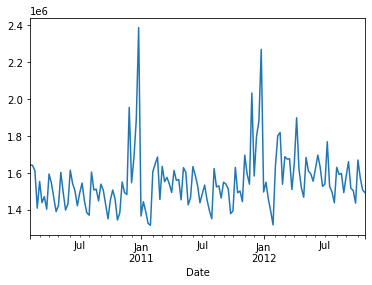

In [45]:
df['Weekly_Sales'].plot()

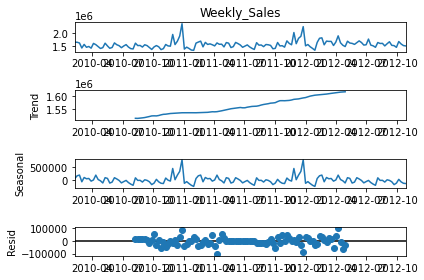

In [56]:
decomposition = seasonal_decompose(df['Weekly_Sales'])

decomposition.plot();

There is a trend and there is also seasonality. Most likely, the final method we looked at above will be the best fit. Let's evaluate it against a simple moving average using train and test splits:

In [48]:
train = df.loc['2010': '2012-01']
test = df.loc['2012-02':]

##### Simple Average:

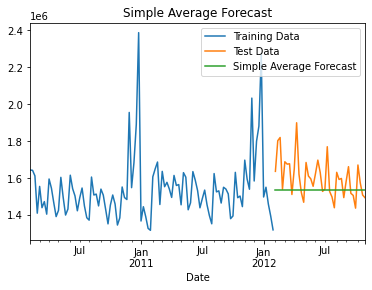

In [49]:
simple_avg = train['Weekly_Sales'].mean()

simple_test = test.copy()

simple_test['forecast'] = simple_avg

train['Weekly_Sales'].plot(label = 'Training Data') 
simple_test['Weekly_Sales'].plot(label = 'Test Data')
simple_test['forecast'].plot(label = 'Simple Average Forecast')
plt.legend(loc = 'best')
plt.title('Simple Average Forecast')

plt.show();

In [50]:
rms = sqrt(mean_squared_error(simple_test['Weekly_Sales'], simple_test['forecast']))  # replace col name as needed 
print(rms)

122190.58215024063


##### Exponential smoothing with both trend and seasonality:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


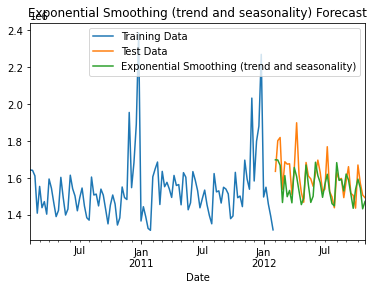

In [57]:
es_both_test = test.copy()

model = ExponentialSmoothing(train['Weekly_Sales'], trend = 'add', seasonal = 'add').fit() # change or remove period if needed, replace col name

es_both_test['forecast'] = model.forecast(len(test))

train['Weekly_Sales'].plot(label = 'Training Data')
es_both_test['Weekly_Sales'].plot(label = 'Test Data')
es_both_test['forecast'].plot(label = "Exponential Smoothing (trend and seasonality)")
plt.legend(loc = 'best')
plt.title("Exponential Smoothing (trend and seasonality) Forecast")

plt.show();

In [58]:
rms = sqrt(mean_squared_error(simple_test['Weekly_Sales'], es_both_test['forecast']))  # replace col name as needed 
print(rms)

87679.73595927103


This model has evaluated with far less error and visibly looks to map to the data quite well, we should use this one when building the model to forecast into the future.

In [60]:
model = ExponentialSmoothing(df['Weekly_Sales'], trend = 'add', seasonal = 'add').fit()
forecast = model.forecast(104)

print(forecast)

2012-11-04    1.735533e+06
2012-11-11    1.643297e+06
2012-11-18    1.599245e+06
2012-11-25    2.087154e+06
2012-12-02    1.649210e+06
                  ...     
2014-09-28    1.541689e+06
2014-10-05    1.764521e+06
2014-10-12    1.662353e+06
2014-10-19    1.608405e+06
2014-10-26    1.599972e+06
Freq: W-SUN, Length: 104, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [61]:
forecast_table = pd.DataFrame(forecast, columns = ['forecast'])
forecast_table.head()

,forecast
2012-11-04,1.735533e+06
2012-11-11,1.643297e+06
2012-11-18,1.599245e+06
2012-11-25,2.087154e+06
2012-12-02,1.649210e+06


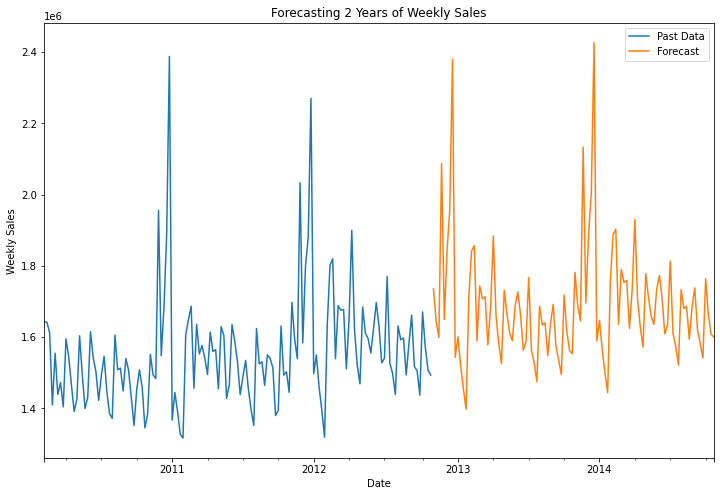

In [62]:
plt.figure(figsize=(12,8))

df['Weekly_Sales'].plot(label = 'Past Data')

forecast_table['forecast'].plot(label = 'Forecast')

plt.title('Forecasting 2 Years of Weekly Sales')
plt.ylabel('Weekly Sales')
plt.legend(loc='best')

plt.show();

Remember to bear in mind that, while we've evalurated these models and chosen the one with the best likihood of mapping our future data well, this is still a forecast. We can never be 100% certain that our forecasts will perform well in the future - if we could we'd all be off getting rich on the stock market! This is a best guess, which can be used to prepare and strategise, but it shouldn't be treated as a certainty.